# Prevendo Temperatura


Vamos investigar a autocorrelação de uma série temporal univariada para então desenvolver um modelo autoregressivo e usa-lo para fazer predições.


Vamos usar o arquivo "daily-min-temperatures.csv" que possui a temperatura mínima de 10 anos (1981-1990) da cidade de Melbourne, Australia.

As unidades estão em graus Celsius e existem 3.650 observações. A fonte dos dados é creditada como o Australian Bureau of Meteorology.




In [12]:
#Vamos importar as bibliotecas que vamos utilizar

import pandas as pd
import matplotlib as mtl
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


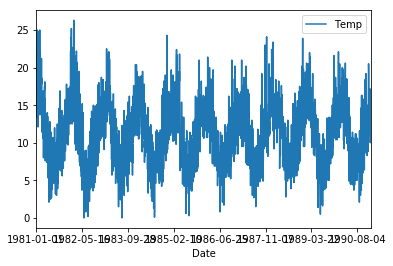

In [13]:
#Primeiramente vamos importar os dados e armazena-los em um pandas dataframe

series = pd.read_csv('daily-min-temperatures.csv', header=0, index_col=0)

#Vamos plotar as 5 primeiras linhas para verificar o dataser carregado
print(series.head())

#E Então plotar em um gráfico de linhas para analisa-lo
series.plot()
mtl.pyplot.show()


# Verificação rápida de autocorrelação

Há uma verificação visual rápida que podemos fazer para checar se há uma autocorrelação em nosso conjunto de dados de séries temporais.

Podemos plotar a observação do periodo anterior (t-1) com a observação do próximo periodo (t + 1) em um gráfico de dispersão.

Isso pode ser feito manualmente, primeiro criando uma versão lag do conjunto de dados de séries temporais e usando uma função de plotagem de dispersão incorporada na biblioteca do Pandas.

Mas existe uma maneira mais fácil.

O Pandas fornece um gráfico embutido para fazer exatamente isso, chamado de função lag_plot ().

Abaixo está um exemplo de criação de um gráfico de lag do conjunto de dados de Temperaturas Diárias Mínimas.

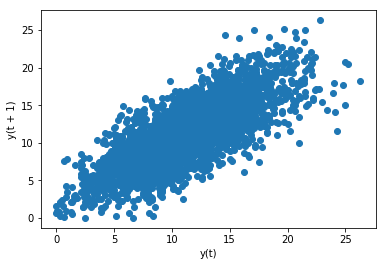

In [14]:
pd.plotting.lag_plot(series)
mtl.pyplot.show()

A execução acima plota os dados de temperatura (t) no eixo x em relação à temperatura no dia anterior (t-1) no eixo y.

Podemos ver uma grande bola de observações ao longo de uma linha diagonal do gráfico. Isso mostra claramente um relacionamento ou alguma correlação.

Esse processo pode ser repetido para qualquer outra observação para trás , como se quiséssemos revisar a correlação nos últimos 7 dias ou com o mesmo dia do mês passado ou do ano passado.

Outra verificação rápida que podemos fazer é calcular diretamente a correlação entre a observação e a variável lag.

Podemos usar um teste estatístico como o coeficiente de correlação de Pearson. Isso produz um número para resumir a correlação entre duas variáveis entre -1 (correlação negativa) e +1 (correlação positiva) com valores pequenos próximos a zero indicando baixa correlação e valores altos acima de 0,5 ou abaixo de -0,5 mostrando alta correlação.

A correlação pode ser calculada facilmente usando a função corr () no DataFrame do conjunto de dados com lag.

O exemplo abaixo cria uma versão defasada do conjunto de dados de Temperaturas Diárias Mínimas e calcula uma matriz de correlação de cada coluna com outras colunas, incluindo ela própria.

In [15]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


Esta é uma boa confirmação para o gráfico acima pois mostra uma forte correlação positiva (0,77) entre a observação e o valor de lag - 1.

Isso é bom para verificações pontuais, mas trabalhoso se quisermos verificar um grande número de variáveis de lag em nossa série temporal.

A seguir, veremos uma versão facilitada dessa abordagem.


# Gráficos de autocorrelação

Podemos traçar o coeficiente de correlação para cada variável de lag.

Isso pode rapidamente dar uma idéia de quais variáveis de lag podem ser boas candidatas para uso em um modelo preditivo e como a relação entre a observação e seus valores históricos mudam com o tempo.

Poderíamos calcular manualmente os valores de correlação para cada variável de lag e plotagem. Felizmente, o Pandas fornece um gráfico interno chamado função autocorrelation_plot ().

O gráfico fornece o número de atraso ao longo do eixo x e o valor do coeficiente de correlação entre -1 e 1 no eixo y. O gráfico também inclui linhas sólidas e tracejadas que indicam o intervalo de confiança de 95% e 99% para os valores de correlação. Os valores de correlação acima dessas linhas são mais significativos que os abaixo da linha, fornecendo um limite ou ponto de corte para a seleção de valores de lag mais relevantes.

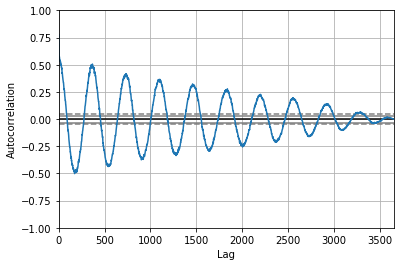

In [16]:
pd.plotting.autocorrelation_plot(series)
mtl.pyplot.show()

A execução do exemplo acima mostra o balanço na correlação positiva e negativa, à medida que os valores de temperatura mudam nas estações de verão e inverno a cada ano anterior.


# Gráfico de Autocorrelação de Pandas

A biblioteca statsmodels também fornece uma versão do gráfico na função plot_acf () como um gráfico de linhas.

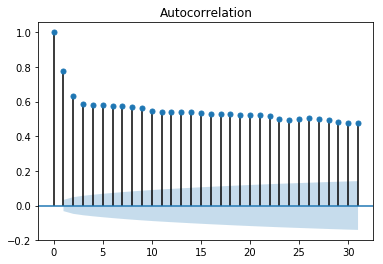

In [17]:
plot_acf(series, lags=31)
mtl.pyplot.show()

Neste exemplo, limitamos as variáveis de lag avaliadas em 31 para facilitar a leitura.

# Gráfico de Autocorrelação de Statsmodels


Agora que sabemos como revisar a autocorrelação em nossas séries temporais, vejamos a modelagem de autoregressão.

Antes de fazer isso, vamos estabelecer um desempenho de linha de base.

# Modelo de persistência

Digamos que queremos desenvolver um modelo para prever os últimos 7 dias de temperaturas mínimas no conjunto de dados, com todas as observações anteriores.

O modelo mais simples que poderíamos usar para fazer previsões seria persistir na última observação. Podemos chamar isso de modelo de persistência e fornece uma linha de base de desempenho para o problema que podemos usar para comparação com um modelo de autoregressão.

Podemos desenvolver um equipamento de teste para o problema dividindo as observações em conjuntos de treinamento e teste, com apenas as últimas 7 observações no conjunto de dados atribuídas ao conjunto de testes como dados "não vistos" que desejamos prever.

As previsões são feitas usando um modelo de validação direta, para que possamos persistir nas observações mais recentes do dia seguinte. Isso significa que não estamos fazendo uma previsão de 7 dias, mas 7 previsões de 1 dia.

Test MSE: 3.423


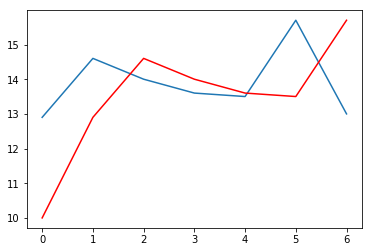

In [18]:
# cria lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

# divide em treino and test 
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# cria modelo persistencia
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plota predição vs esperado
mtl.pyplot.plot(test_y)
mtl.pyplot.plot(predictions, color='red')
mtl.pyplot.show()

A execução do exemplo imprime o erro quadrático médio (MSE).

O valor fornece um desempenho de linha de base para o problema.Os valores esperados para os próximos 7 dias são plotados (azul) em comparação com as previsões do modelo (vermelho).

# Modelo de autoregressão

Um modelo de regressão automática é um modelo de regressão linear que usa variáveis lag como variáveis de entrada.

Poderíamos calcular o modelo de regressão linear manualmente usando a classe LinearRegession no scikit-learn e especificar manualmente as variáveis de entrada de lag a serem usadas.

Como alternativa, a biblioteca statsmodels fornece um modelo de regressão automática que seleciona automaticamente um valor de lag apropriado usando testes estatísticos e treina um modelo de regressão linear. É fornecido na classe AR.

Podemos usar esse modelo criando primeiro o modelo AR () e depois chamando fit () para treiná-lo em nosso conjunto de dados. Isso retorna um objeto ARResult.

Uma vez ajustado, podemos usar o modelo para fazer uma previsão chamando a função predict () para várias observações no futuro. Isso cria uma previsão de 7 dias, que é diferente do exemplo de persistência acima.



Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test MSE: 1.502


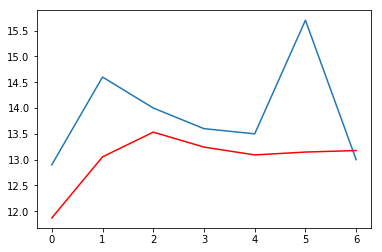

In [19]:
# divide dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# treina autoregressão
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# faz predições
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plota resultados
mtl.pyplot.plot(test)
mtl.pyplot.plot(predictions, color='red')
mtl.pyplot.show()

A execução do exemplo  imprime o primeiro lag ideal escolhido e a lista de coeficientes no modelo de regressão linear treinado.

Podemos ver que um modelo de 29 lag foi escolhido e treinado. Isso é interessante, dado o quão próximo esse atraso está do número médio de dias em um mês.

A previsão de 7 dias é impressa e o erro quadrático médio da previsão é sumarizado.

É feito um gráfico dos valores esperados (azul) versus os valores previstos (vermelho).

A previsão parece muito boa (cerca de 1 grau Celsius por dia), com um grande desvio no dia 5.

Previsões do modelo de AR fixo
Previsões do modelo de AR fixo

Neste exercício, aprendemos como fazer previsões de autoregressão para dados de séries temporais usando Python.

Você aprendeu especificamente:

Sobre autocorrelação e autoregressão e como eles podem ser usados para entender melhor os dados de séries temporais.
Como explorar a autocorrelação em uma série temporal usando gráficos e testes estatísticos.
Como treinar um modelo de regressão automática em Python e usá-lo para fazer previsões de curto prazo e contínuas.